In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import networkx as nx

In [60]:
def phi_inverse_hops(a, A, alpha):
    # Assumes that A is shortest path matrix
    if alpha == 0:
        new_a = torch.where(A==1, a, torch.zeros_like(a))
    else:
        new_a = 1./torch.pow(A, 1/alpha) * a
    new_a = F.normalize(new_a, p=1, dim=-1)
    print(new_a)
    return new_a




In [14]:
NUM_NODES = 5

In [15]:
def plot_mat(mat):
    # Create figure that is smaller then the default
    plt.figure(figsize=(4, 4))
    plt.imshow(mat, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

In [16]:
# Make sure the colormap is shared over all subplots
def plot_three_mats(mat1, mat2, mat3,mat4, title):
    vmin = min(mat2.min(), mat3.min())
    vmax = max(mat2.max(), mat3.max())
    # Create figure that is smaller then the default
    # plt.figure(figsize=(12, 4))
    f, axs = plt.subplots(1,4, figsize=(12, 4))
    im1 = axs[0].imshow(mat1, cmap='afmhot', interpolation='nearest', vmin=0, vmax=1)
    im2 = axs[1].imshow(mat2, cmap='afmhot', interpolation='nearest', vmin=0, vmax=1)
    im3 = axs[2].imshow(mat3, cmap='afmhot', interpolation='nearest', vmin=0, vmax=1)
    im4 = axs[3].imshow(mat4, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
    # add colorbar withouth resizing the figure
    f.colorbar(im1, ax=axs[0], shrink=0.55)    
    f.colorbar(im2, ax=axs[1], shrink=0.55)    
    f.colorbar(im3, ax=axs[2], shrink=0.55)    
    f.colorbar(im4, ax=axs[3], shrink=0.55)    
    axs[0].set_title("Adjacency matrix")
    axs[1].set_title("Original attention matrix")
    axs[2].set_title("Adjacency Aware Attention")
    axs[3].set_title("AAA - Original Attention")
    plt.suptitle(f"Adjacency Aware Attention with Factor {title:.2f}")
    plt.show()
   

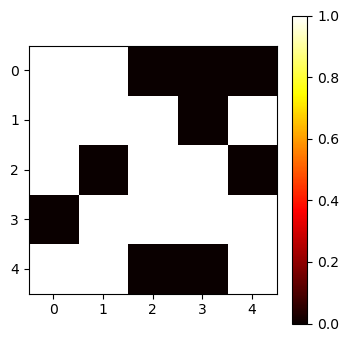

In [39]:
adj_mat = np.random.randint(0, 2, size=(NUM_NODES, NUM_NODES))
np.fill_diagonal(adj_mat, 1)
adj_mat
plot_mat(adj_mat)

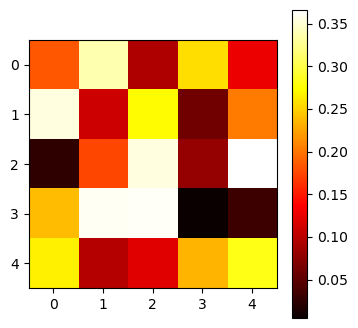

In [18]:
att_mat = np.random.rand(NUM_NODES, NUM_NODES)
att_mat = att_mat/ np.sum(att_mat, axis=1)[:, None]
plot_mat(att_mat)

In [19]:
# Replace all 0s with BETA and all 1s with 1-BETA in adj_mat
def adj_aware_beta(beta):
    corr_mat = np.where(adj_mat == 0, beta, 1-beta)
    corrected_mat = att_mat * corr_mat
    adj_aware_att_mat = corrected_mat/ np.sum(corrected_mat, axis=1, keepdims=True)
    return corr_mat, adj_aware_att_mat

In [20]:
def adj_aware_alpha(alpha):
    adj_aware_att_mat = att_mat * alpha + adj_mat * (1-alpha)
    adj_aware_att_mat = adj_aware_att_mat/ np.sum(adj_aware_att_mat, axis=1, keepdims=True)
    return adj_aware_att_mat

# Version one using $\beta$ * att or (1-$\beta$) * att depending if $e_{i,j} \in A$

[[1 1 2 3 2]
 [1 1 1 2 1]
 [1 2 1 1 2]
 [2 1 1 1 1]
 [1 1 2 3 1]]
[[0.18400749 0.33692152 0.09486683 0.25713404 0.12707011]
 [0.35353404 0.10950267 0.27247817 0.06111421 0.2033709 ]
 [0.02550962 0.1748737  0.35363926 0.0801282  0.36584922]
 [0.23791655 0.36121497 0.36276953 0.00509337 0.03300558]
 [0.26665459 0.09714181 0.12079946 0.23407634 0.2813278 ]]
tensor([[0.2227, 0.4077, 0.0812, 0.1797, 0.1087],
        [0.3600, 0.1115, 0.2774, 0.0440, 0.2071],
        [0.0303, 0.1469, 0.4202, 0.0952, 0.3074],
        [0.1808, 0.3883, 0.3899, 0.0055, 0.0355],
        [0.3080, 0.1122, 0.0987, 0.1561, 0.3250]], dtype=torch.float64)


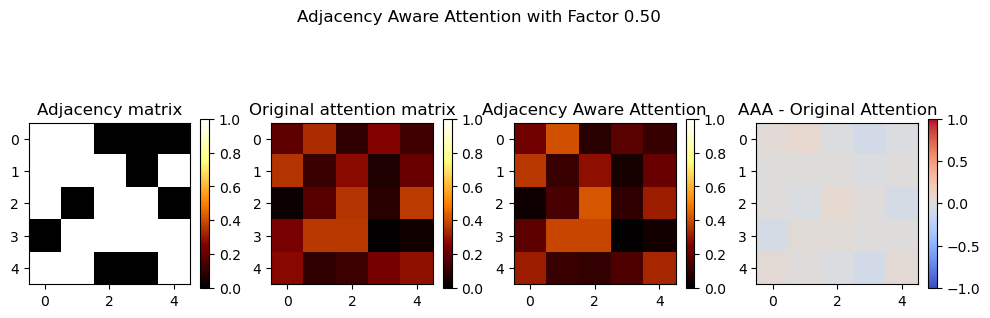

In [75]:

short_dist = nx.shortest_path_length(nx.from_numpy_array(adj_mat,create_using=nx.DiGraph))
short_dist_mat = np.zeros_like(adj_mat)
for i, j_d in short_dist:
    for j, d in j_d.items():
        short_dist_mat[i, j] = d
    short_dist_mat[i, i] = 1
print(short_dist_mat)
print(att_mat)
adj_aw = phi_inverse_hops(torch.tensor(att_mat), torch.tensor(short_dist_mat), 2).numpy()
plot_three_mats(adj_mat, att_mat, adj_aw, adj_aw - att_mat, 0.5)

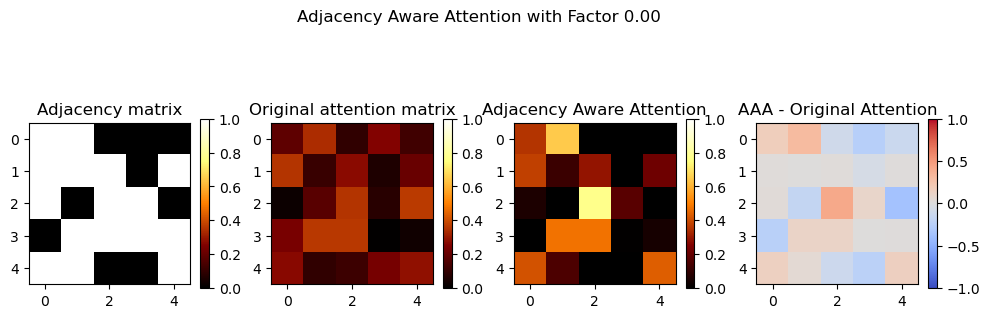

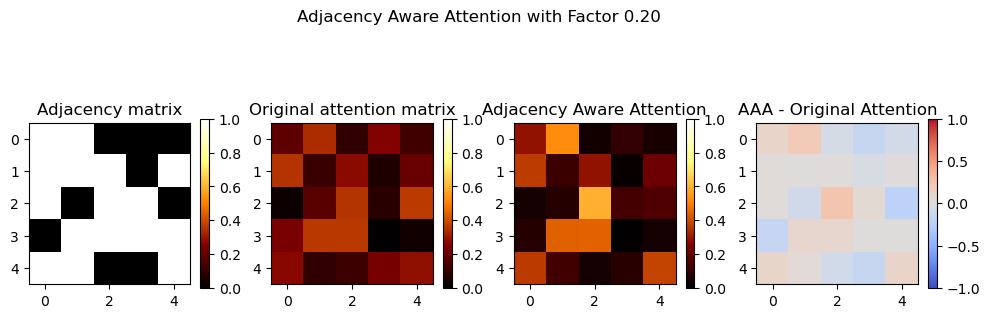

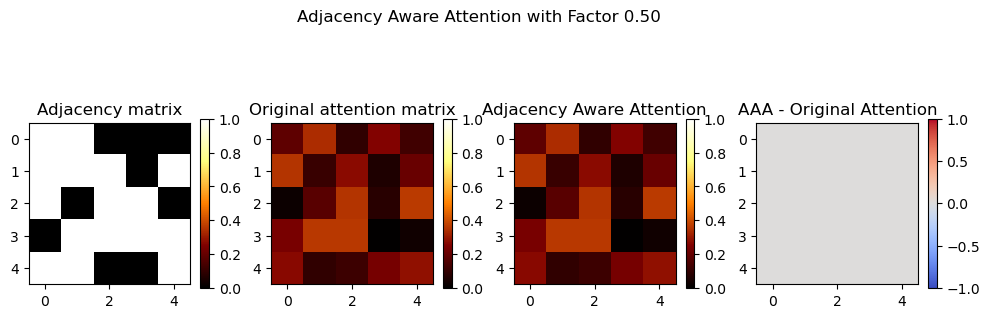

In [68]:
beta = 0
corr_mat, adj_aware_att_mat = adj_aware_beta(beta)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, beta)
beta = 0.2
corr_mat, adj_aware_att_mat = adj_aware_beta(beta)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, beta)
beta = 0.5
corr_mat, adj_aware_att_mat = adj_aware_beta(beta)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, beta)

# Version two using $\alpha$ * att + (1-$\alpha) * A_{i,j}$

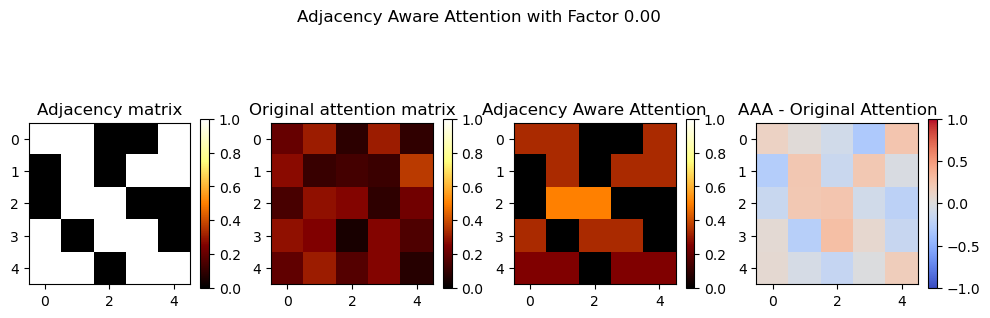

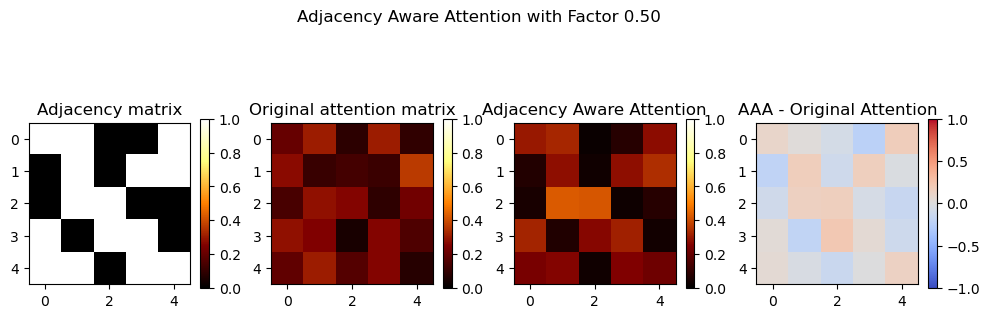

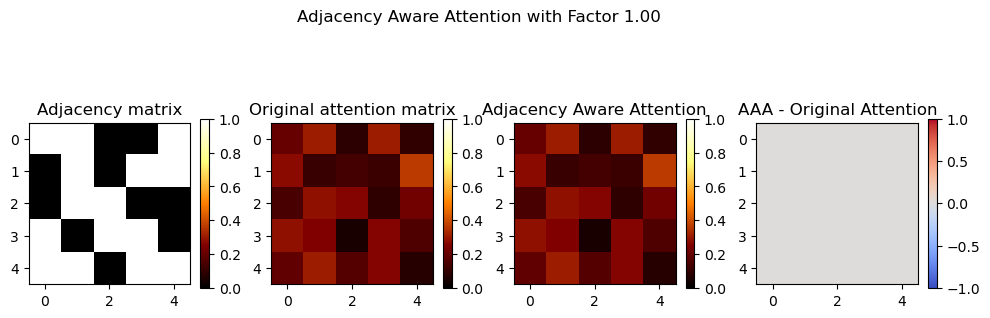

In [ ]:
alpha = 0
adj_aware_att_mat = adj_aware_alpha(alpha)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, alpha)
alpha = 0.5
adj_aware_att_mat = adj_aware_alpha(alpha)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, alpha)
alpha = 1
adj_aware_att_mat = adj_aware_alpha(alpha)
plot_three_mats(adj_mat, att_mat, adj_aware_att_mat, adj_aware_att_mat-att_mat, alpha)